In [153]:
from math import sqrt
import alpaca_trade_api as tradeapi
from datetime import datetime
import pytz
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import json
import pandas as pd

# API credentials
api_key = 'AKQB26E5HLHLA54FOT9T'
api_secret = 'hNgAGISeVTThSFOoa1biaGcRuWYD8HvOvtb1AB7c'
base_url = 'https://paper-api.alpaca.markets'  

# Initialize the Alpaca API
api = tradeapi.REST(api_key, api_secret, base_url, api_version='v2')

symbol = 'SPY' 
start_date = datetime(2021, 1, 1).astimezone(pytz.timezone('UTC')) 
end_date = datetime(2024, 4, 15).astimezone(pytz.timezone('UTC'))  

daily_prices = api.get_bars(symbol, tradeapi.TimeFrame.Day, start_date.isoformat(), end_date.isoformat()).df
print(daily_prices)

# Load JSON data
with open('temp.json', 'r') as file:
    sentiment_data = json.load(file)

# Convert JSON data to DataFrame
sentiment_df = pd.DataFrame(list(sentiment_data.items()), columns=['date', 'sentiment'])
# Convert date to datetime with UTC timezone
sentiment_df['date'] = pd.to_datetime(sentiment_df['date']).dt.tz_localize('UTC')

# Assuming daily_prices is already loaded and indexed with datetime in UTC
# Ensure the daily_prices DataFrame has the correct date format if not done yet
daily_prices.index = pd.to_datetime(daily_prices.index, utc=True)

# Merge the DataFrames on the date index using an inner join
combined_df = pd.merge(daily_prices, sentiment_df, how='inner', left_index=True, right_on='date')

# Now 'combined_df' contains only the dates with both price data and sentiment values
print(combined_df.head())



                            close     high     low  trade_count    open  \
timestamp                                                                 
2021-01-04 05:00:00+00:00  368.97  375.450  364.82       623066  375.31   
2021-01-05 05:00:00+00:00  371.40  372.500  368.05       338929  368.10   
2021-01-06 05:00:00+00:00  373.41  376.980  369.12       575346  369.71   
2021-01-07 05:00:00+00:00  379.13  379.900  375.91       366624  376.10   
2021-01-08 05:00:00+00:00  381.29  381.490  377.10       391374  380.59   
...                           ...      ...     ...          ...     ...   
2024-04-09 04:00:00+00:00  519.32  520.750  514.35       532493  520.50   
2024-04-10 04:00:00+00:00  514.12  516.160  512.09       753675  513.48   
2024-04-11 04:00:00+00:00  518.00  519.480  512.08       582634  515.68   
2024-04-12 04:00:00+00:00  510.85  515.815  509.08       767726  514.37   
2024-04-15 04:00:00+00:00  504.45  515.300  503.58       841318  515.13   

                        

In [154]:
X = daily_prices[['close', 'high', 'low', 'trade_count', 'open']]
Y = daily_prices['volume']

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


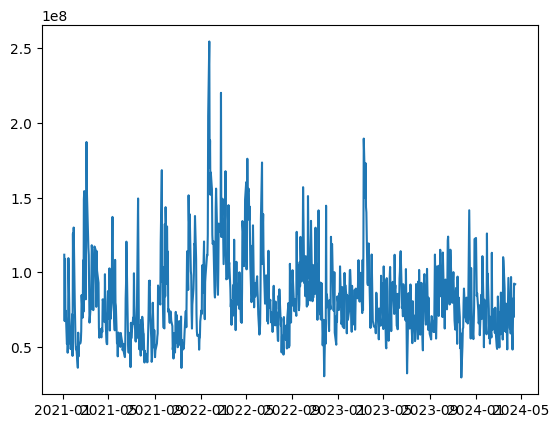

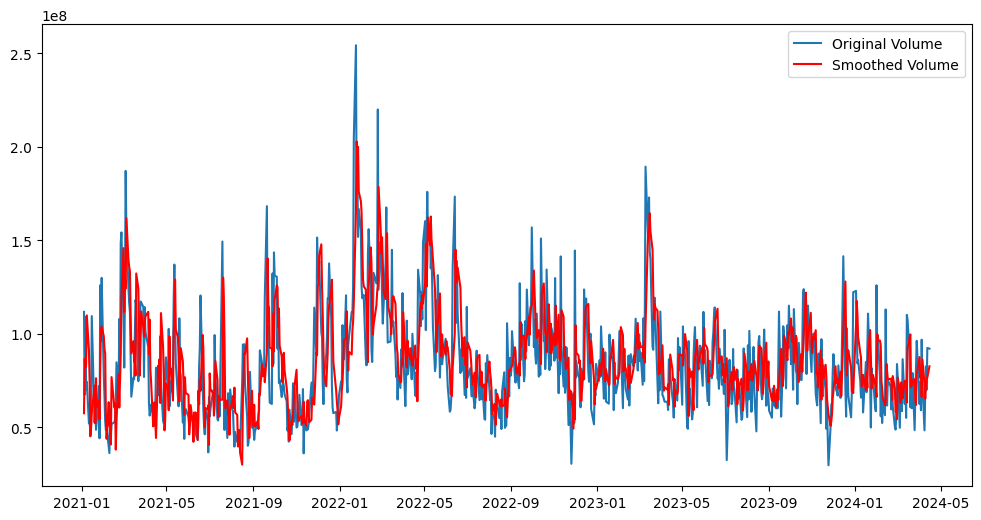

In [155]:
# Exponential Smoothing
model = ExponentialSmoothing(Y, trend="add", seasonal="add", seasonal_periods=12)
fitted_model = model.fit()

plt.plot(Y)
plt.show()

# Plot original data and smoothed data
plt.figure(figsize=(12, 6))
plt.plot(Y.index, Y, label='Original Volume')
plt.plot(Y.index, fitted_model.fittedvalues, label='Smoothed Volume', color='red')
plt.legend()
plt.show()

y_smooth = fitted_model.fittedvalues

In [156]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=40)

In [157]:
# DECISION TREE MODEL

regressor = DecisionTreeRegressor(random_state=40)
regressor.fit(X_train, y_train)

predictions = regressor.predict(X_test)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f"Mean Squared Error: {sqrt(mse)}")
print(f"R-squared: {r2}")

Mean Squared Error: 15646354.792929037
R-squared: 0.7233342422406267


In [158]:
# XGB BOOST MODEL

regressor = xgb.XGBRegressor(n_estimators=100, random_state=40)
regressor.fit(X_train, y_train)

predictions = regressor.predict(X_test)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f"Mean Squared Error: {sqrt(mse)}")
print(f"R-squared: {r2}")

Mean Squared Error: 13005548.817024
R-squared: 0.808844662030796


In [159]:
# FOREST MODEL

regressor = RandomForestRegressor(n_estimators=100, random_state=40)
regressor.fit(X_train, y_train)

predictions = regressor.predict(X_test)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f"Mean Squared Error: {sqrt(mse)}")
print(f"R-squared: {r2}")

Mean Squared Error: 12077561.265054174
R-squared: 0.835150527679512


In [160]:
# NEURAL NETWORK

In [161]:
# DECISION TREE MODEL AND SMOOTHED

X_train, X_test, y_train, y_test = train_test_split(X, y_smooth, test_size=0.2, random_state=40)

regressor = DecisionTreeRegressor(random_state=40)
regressor.fit(X_train, y_train)

predictions = regressor.predict(X_test)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f"Mean Squared Error: {sqrt(mse)}")
print(f"R-squared: {r2}")

Mean Squared Error: 24086380.981004708
R-squared: 0.11080114088134763


In [162]:
# XGB BOOST MODEL and SMOOTHED

X_train, X_test, y_train, y_test = train_test_split(X, y_smooth, test_size=0.2, random_state=40)

regressor = xgb.XGBRegressor(n_estimators=100, random_state=40)
regressor.fit(X_train, y_train)

predictions = regressor.predict(X_test)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f"Mean Squared Error: {sqrt(mse)}")
print(f"R-squared: {r2}")

Mean Squared Error: 18935337.65805933
R-squared: 0.4504567196352707


In [163]:
# FOREST MODEL AND SMOOTHED

X_train, X_test, y_train, y_test = train_test_split(X, y_smooth, test_size=0.2, random_state=40)

regressor = RandomForestRegressor(n_estimators=100, random_state=40)
regressor.fit(X_train, y_train)

predictions = regressor.predict(X_test)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f"Mean Squared Error: {sqrt(mse)}")
print(f"R-squared: {r2}")

Mean Squared Error: 17906099.638341535
R-squared: 0.5085743876071268
